In [1]:
# Modifying the provided 'edited-model.py' to incorporate suggested improvements

# Modified script content with additional tuning, early stopping, and class distribution checks.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
#import the tensoflow libarys, these handel the the test/train split of the data, the model creation and the model comparison
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorboard import notebook

In [3]:
# Load the data
df = pd.read_csv('C:/Users/honey/Documents/placment work/Electronical-AI-Device-Recogniser/khanya/data managment/datasets/acs-f2-dataset.csv')

In [4]:

# Drop the 'time' column as it's not relevant for prediction
df = df.drop('time', axis=1)


In [5]:
# Convert categorical labels to numeric
le = LabelEncoder()
df['equipment'] = le.fit_transform(df['equipment'])

# Split features and labels
X = df.drop('equipment', axis=1)
y = df['equipment']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# One-hot encode the labels
y_resampled_onehot = to_categorical(y_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_onehot, test_size=0.2, random_state=42)

In [14]:
from tensorflow.keras.layers import Input, Concatenate, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define the model architecture with weighted input for 'freq' column and dropout
input_layer = Input(shape=(X_train.shape[1],))
freq_weight = K.constant([[2.0]])  # Convert the weight to a tensor with the same shape as freq_input

# Split the input into 'freq' and other features
freq_input = input_layer[:, 0:1]
other_features = input_layer[:, 1:]

# Apply the weight to the 'freq' column
weighted_freq = Multiply()([freq_input, freq_weight])

# Concatenate the weighted 'freq' column back with the other features
weighted_input = Concatenate()([weighted_freq, other_features])

# Define the rest of the model
x = Dense(256, activation='relu')(weighted_input)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
num_classes = y_resampled_onehot.shape[1]
output_layer = Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate for better generalization
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with early stopping and TensorBoard callback
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=500, 
                    batch_size=64, 
                    callbacks=[early_stopping, tensorboard_callback])


Epoch 1/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.1700 - loss: 3.9953 - val_accuracy: 0.3627 - val_loss: 1.8164
Epoch 2/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3418 - loss: 1.8653 - val_accuracy: 0.4195 - val_loss: 1.5881
Epoch 3/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4200 - loss: 1.6384 - val_accuracy: 0.5278 - val_loss: 1.4362
Epoch 4/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4617 - loss: 1.5306 - val_accuracy: 0.5303 - val_loss: 1.3375
Epoch 5/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5005 - loss: 1.4149 - val_accuracy: 0.5383 - val_loss: 1.2801
Epoch 6/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5174 - loss: 1.3651 - val_accuracy: 0.5555 - val_loss: 1.2350
Epoch 7/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5293 - loss: 1.3255 - val_accuracy: 0.5716 - val_loss: 1.1697
Epoch 8/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5397 - loss: 1

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step


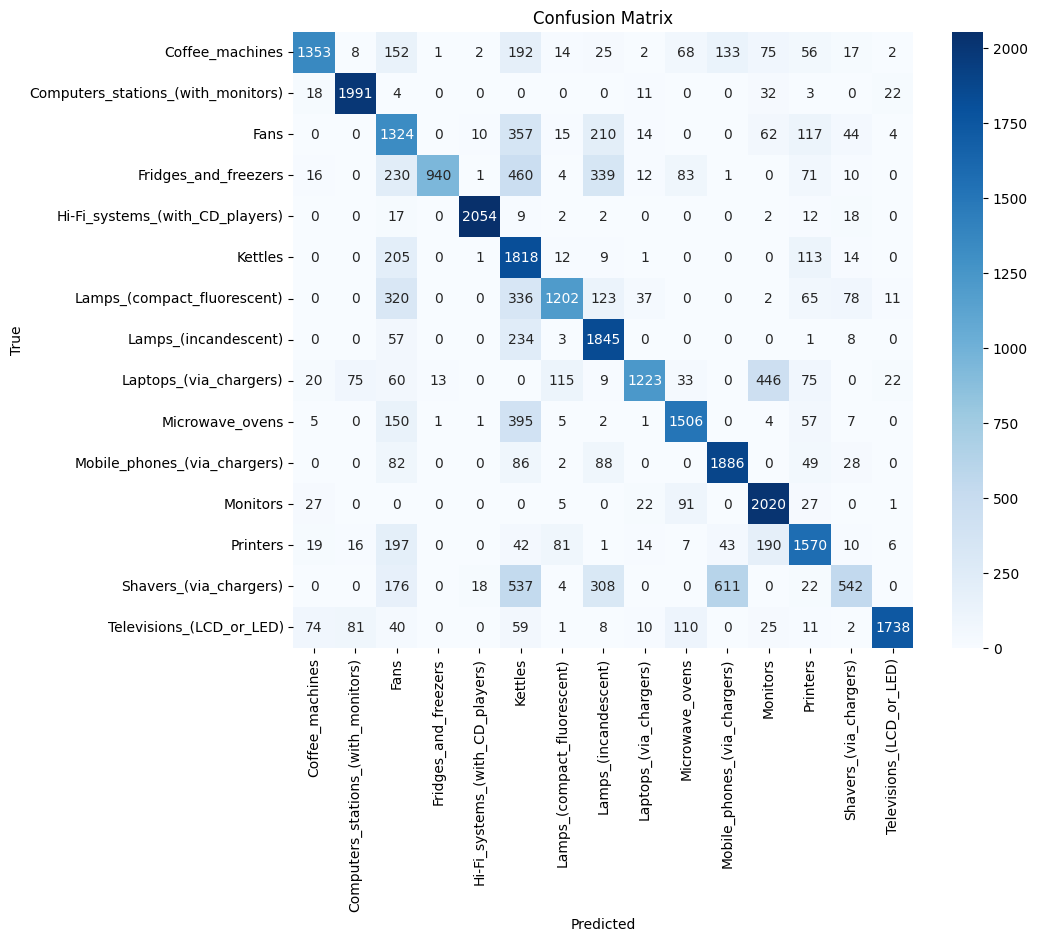

In [15]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [8]:
# Save the trained model and the scaler for future use
model.save('new-model1.0.4.keras')
scaler = StandardScaler().fit(X_train)
joblib.dump(scaler, 'new-scaler1.0.4.pkl')

['new-scaler1.0.4.pkl']